<a href="https://colab.research.google.com/github/FEIFEIEIAr/Hello-World/blob/main/NN_%E6%B0%94%E6%B8%A9%E9%A2%84%E6%B5%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

In [ ]:
# 通过python console查看维度
features = pd.read_csv('temps.csv')
features.head()

In [ ]:
print('数据维度：', features.shape)

In [ ]:
# 处理时间数据
import datetime

years = features['year']
months = features['month']
days = features['day']

# datetime格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(date)) for year,month,date in zip(years,months,days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

dates[:5]

In [ ]:
# 画图
# 风格
plt.style.use('fivethirtyeight')

# 设置布局
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
fig.autofmt_xdate(rotation=45)

# 标签值
ax1.plot(dates, features["actual"])
ax1.set_xlabel('');ax1.set_ylabel("Temperature");ax1.set_title("Max Temp")

# 昨天
ax2.plot(dates, features["temp_1"])
ax2.set_xlabel('');ax1.set_ylabel("Temperature");ax1.set_title("Previous Max Temp")

# 前天
ax3.plot(dates, features["temp_2"])
ax3.set_xlabel('Date');ax1.set_ylabel("Temperature");ax1.set_title("Two Days Prior Max Temp")

# 朋友
ax4.plot(dates, features["friend"])
ax4.set_xlabel('Date');ax1.set_ylabel("Temperature");ax1.set_title("Friend's Estimate")

plt.tight_layout(pad=2)

In [ ]:
# 独热编码
features = pd.get_dummies(features)  # 除掉不是数值的
features.head(5)

In [ ]:
# 标签
labels = np.array(features['actual'])

# 除掉features中的标签
features = features.drop('actual', axis = 1)

# 名字单独保存一下，以备后患
feature_list = list(features.columns)
features.head(5)

In [ ]:
features = np.array(features)
print(features[:2,:])
features.shape

In [ ]:
from sklearn import preprocessing
# 特征标准化处理
input_features = preprocessing.StandardScaler().fit_transform(features)
print(input_features[0], type(input_features))

# 网络

In [ ]:
# 转为tensor格式
x = torch.tensor(input_features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.float)

In [ ]:
# 权重初始化--标准正态分布
weights1 = torch.randn((14, 128), dtype=torch.float, requires_grad=True)  # (14, 128)---14个input，128个units
biases1 = torch.randn(128, dtype=torch.float, requires_grad=True)
weights2 = torch.randn((128, 1), dtype=torch.float, requires_grad=True)  # 回归任务
biases2 = torch.randn(1, dtype=torch.float, requires_grad=True)

# 超参初始化
learning_rate = 0.001
losses = []

In [ ]:
for i in range(1000):
    # 计算隐层
    hidden = x.mm(weights1) + biases1  # .mm is matrix multiply
    # 加入激活函数
    hidden =torch.relu(hidden)
    # 预测结果
    predictions = hidden.mm(weights2) + biases2
    # 计算损失
    loss = torch.mean((predictions - y) ** 2)
    losses.append(loss.data.numpy())

    # 打印损失
    if i % 100 == 0:
      print('loss=', loss)
    
    # 反向传播
    loss.backward()

    # 更新参数
    weights1.data.add_(-learning_rate * weights1.grad.data)
    biases1.data.add_(-learning_rate * biases1.grad.data)
    weights2.data.add_(-learning_rate * weights2.grad.data)
    biases2.data.add_(-learning_rate * biases2.grad.data)

    # 每次迭代清空
    weights1.grad.data.zero_()
    biases1.grad.data.zero_()
    weights2.grad.data.zero_()
    biases2.grad.data.zero_()

loss= tensor(8400.5527, grad_fn=<MeanBackward0>)
loss= tensor(154.0570, grad_fn=<MeanBackward0>)
loss= tensor(147.6631, grad_fn=<MeanBackward0>)
loss= tensor(144.9709, grad_fn=<MeanBackward0>)
loss= tensor(143.4332, grad_fn=<MeanBackward0>)
loss= tensor(142.4687, grad_fn=<MeanBackward0>)
loss= tensor(141.8119, grad_fn=<MeanBackward0>)
loss= tensor(141.3421, grad_fn=<MeanBackward0>)
loss= tensor(140.9860, grad_fn=<MeanBackward0>)
loss= tensor(140.7092, grad_fn=<MeanBackward0>)


###  another

In [ ]:
# 更简单的，全部用torch内置函数完成的模型训练
input_size = input_features.shape[1]
hidden_size = 128
output_size = 1
batch_size = 16
lr = 0.001

simple_nn = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(hidden_size, output_size)
)
cost = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(simple_nn.parameters(), lr=lr)

In [ ]:
# 训练
for i in range(1000):
    batch_loss = []
    # MINI-Batch方法来进行训练
    for start in range(0, len(input_features), batch_size):
        end = start + batch_size if start + batch_size < len(input_features) else len(input_features)
        xx = torch.tensor(input_features[start:end], dtype=torch.float, requires_grad=True)
        yy = torch.tensor(labels[start:end], dtype=torch.float, requires_grad=True)
        prediction = simple_nn(xx)
        # 降为一维，否则loss会告警
        prediction = prediction.squeeze(-1)
        loss = cost(prediction, yy)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        batch_loss.append(loss.data.numpy())

    # 打印损失
    if i % 100 == 0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

0 3983.708
100 21.302828
200 18.273134
300 17.31605
400 16.526161
500 15.855755
600 15.365078
700 14.966653
800 14.638556
900 14.3619375


# 预测

In [ ]:
x = torch.tensor(input_features, dtype=torch.float)
predict = simple_nn(x).data.numpy()

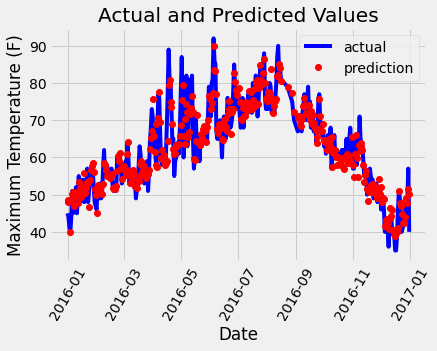

In [ ]:

# 转换日期格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# 创建一个表格来存日期和其对应的标签数值
true_data = pd.DataFrame(data={'date': dates, 'actual': labels})
predictions_data = pd.DataFrame(data={'date': dates, 'prediction': predict.reshape(-1)})

# 真实值
plt.plot(true_data['date'], true_data['actual'], 'b-', label='actual')

# 预测值
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label='prediction')
plt.xticks(rotation='60')
plt.legend()

# 图名
plt.xlabel('Date')
plt.ylabel('Maximum Temperature (F)')
plt.title('Actual and Predicted Values')
plt.show()